# Rescheduling mit Flow Time
> Planunghorizont Tag 0: 2 Tage
> Rescheduling des Tages 1

In [1]:
# Datenzugriff
from configs.config import get_path

# Utils
import src.utils.presenter as show
from src.utils.production_process import convert
from src.utils.production_process import initialize as init
from src.utils.analize import check_constrains as check

from src.utils.production_process import time_determination as term
from src.utils.production_process import filter as process_filter

# Solver Model
from src.models.lp import flowtime_scheduling as lp_ft_schedule
from src.models.lp import flowtime_rescheduling as lp_ft_reschedule

# Simulation
from src.simulation.ProductionDaySimulation import ProductionDaySimulation

# Extern
import pandas as pd
pd.set_option('display.min_rows', 16)
pd.set_option('display.max_rows', 21)

In [2]:
max_time = 60*10 # 10 min

In [3]:
basic_data_path = get_path("data", "basic")

df_instance = pd.read_csv(basic_data_path / "instance.csv")
df_instance

,Production_Plan_ID,Operation,Machine,Processing Time
0,0,0,M00,29
1,0,1,M01,78
2,0,2,M02,9
3,0,3,M03,36
4,0,4,M04,49
5,0,5,M05,11
6,0,6,M06,62
7,0,7,M07,56
...,...,...,...,...
92,9,2,M02,61


## 1) Aufträge generieren für 1 Tag

In [4]:
day_count = 1

df_jssp, df_job_times = init.create_production_orders_for_shifts(
    df_template=df_instance,
    shift_count=day_count,
    shift_length=1440,
    shuffle=True,
    job_seed=40,
    arrival_seed=80
)
df_job_times

,Job,Production_Plan_ID,Arrival
0,0,0,51
1,1,1,136
2,2,2,158
3,3,3,236
4,4,4,404
5,5,5,485
6,6,6,501
7,7,7,528
8,8,8,550
9,9,9,559


In [5]:
df_jssp

,Job,Production_Plan_ID,Operation,Machine,Processing Time
0,0,0,0,M00,29
1,0,0,1,M01,78
2,0,0,2,M02,9
3,0,0,3,M03,36
4,0,0,4,M04,49
5,0,0,5,M05,11
6,0,0,6,M06,62
7,0,0,7,M07,56
...,...,...,...,...,...
172,17,3,2,M00,71


## I) Complete Scheduling

In [6]:
# Scheduling
df_schedule = lp_ft_schedule.solve_jssp(df_jssp, df_job_times, solver= "HiGHS", var_cat="Integer", msg=False, timeLimit=max_time, gapRel= 0.05)
df_schedule

BigM: 11000

Solver-Informationen:
  Summe Flow Times        : 11710.0
  Solver-Status           : Optimal
  Anzahl Variablen        : 1728
  Anzahl Constraints      : 3240
  Laufzeit                : ~600.36 Sekunden


,Job,Production_Plan_ID,Operation,Arrival,Machine,Start,Processing Time,Flow time,End
0,0,0,0,51,M00,51.0,29.0,29.0,80.0
1,0,0,1,51,M01,80.0,78.0,107.0,158.0
2,0,0,2,51,M02,158.0,9.0,116.0,167.0
3,0,0,3,51,M03,167.0,36.0,152.0,203.0
4,0,0,4,51,M04,203.0,49.0,201.0,252.0
5,0,0,5,51,M05,252.0,11.0,212.0,263.0
6,0,0,6,51,M06,263.0,62.0,274.0,325.0
7,0,0,7,51,M07,325.0,56.0,330.0,381.0
...,...,...,...,...,...,...,...,...,...
172,17,3,2,1343,M00,1681.0,71.0,409.0,1752.0


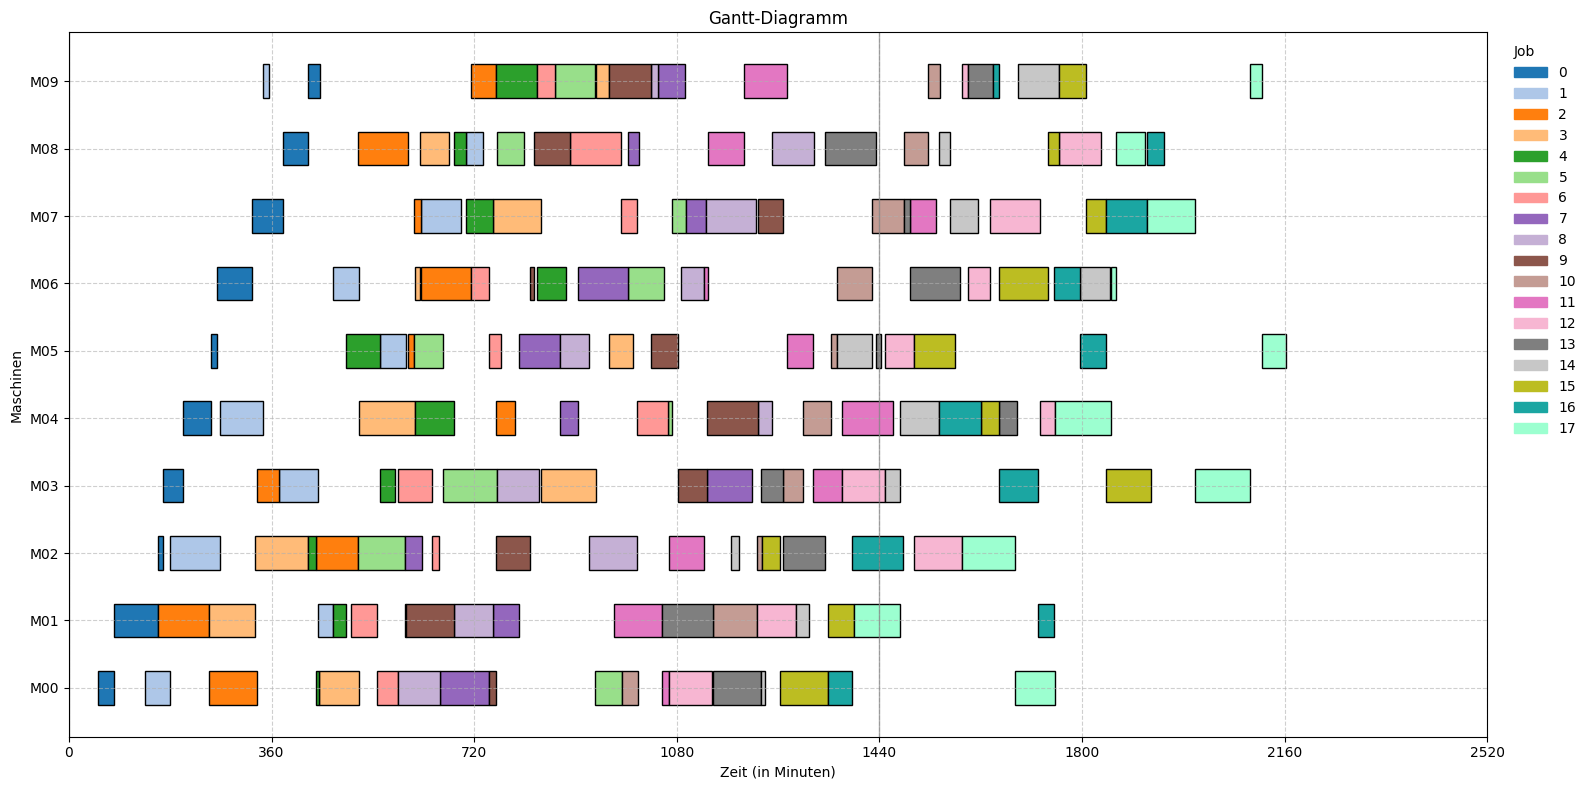

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [7]:
show.plot_gantt(df_schedule, perspective="Machine")
check.is_machine_conflict_free(df_schedule)
check.is_operation_sequence_correct(df_schedule)
check.is_job_timing_correct(df_schedule)
check.is_start_correct(df_schedule)

## II) Erster Tag (Tag 0)

### a) Simulation

In [8]:
day_length = 1440

In [9]:
day_numb = 0

day_start = day_length*day_numb 
day_end = day_start + day_length

In [10]:
simulation = ProductionDaySimulation(df_schedule, vc=0.25)
df_execution = simulation.run(start_time = day_start, end_time=day_end)

[00:51:00] Job 0 started on M00
[01:22:55] Job 0 finished on M00 (after 31 minutes 56 seconds)
[01:22:55] Job 0 started on M01
[02:16:00] Job 1 started on M00
[02:39:24] Job 0 finished on M01 (after 76 minutes 28 seconds)
[02:39:24] Job 2 started on M01
[02:39:24] Job 0 started on M02
[02:50:12] Job 0 finished on M02 (after 10 minutes 49 seconds)
[02:50:12] Job 0 started on M03
[03:02:55] Job 1 finished on M00 (after 46 minutes 56 seconds)
[03:02:55] Job 1 started on M02
[03:49:03] Job 0 finished on M03 (after 58 minutes 51 seconds)
[03:49:03] Job 0 started on M04
[04:26:36] Job 0 finished on M04 (after 37 minutes 32 seconds)
[04:26:36] Job 0 started on M05
[04:36:46] Job 0 finished on M05 (after 10 minutes 10 seconds)
[04:36:46] Job 0 started on M06
[04:44:35] Job 2 finished on M01 (after 125 minutes 11 seconds)
[04:44:35] Job 3 started on M01
[04:44:35] Job 2 started on M00
[04:56:30] Job 1 finished on M02 (after 113 minutes 35 seconds)
[04:56:30] Job 1 started on M04
[05:51:33] Job 

In [11]:
df_plan_undone = process_filter.get_unexecuted_operations(df_schedule, df_execution)
df_plan_undone 

,Job,Production_Plan_ID,Operation,Arrival,Machine,Start,Processing Time,Flow time,End
0,7,7,9,528,M03,1134.0,79.0,685.0,1213.0
1,10,0,5,963,M05,1354.0,11.0,402.0,1365.0
2,10,0,6,963,M06,1365.0,62.0,464.0,1427.0
3,10,0,7,963,M07,1427.0,56.0,520.0,1483.0
4,10,0,8,963,M08,1483.0,44.0,564.0,1527.0
5,10,0,9,963,M09,1527.0,21.0,585.0,1548.0
6,11,9,7,969,M03,1322.0,52.0,405.0,1374.0
7,11,9,8,969,M04,1374.0,90.0,495.0,1464.0
...,...,...,...,...,...,...,...,...,...
45,17,3,2,1343,M00,1681.0,71.0,409.0,1752.0


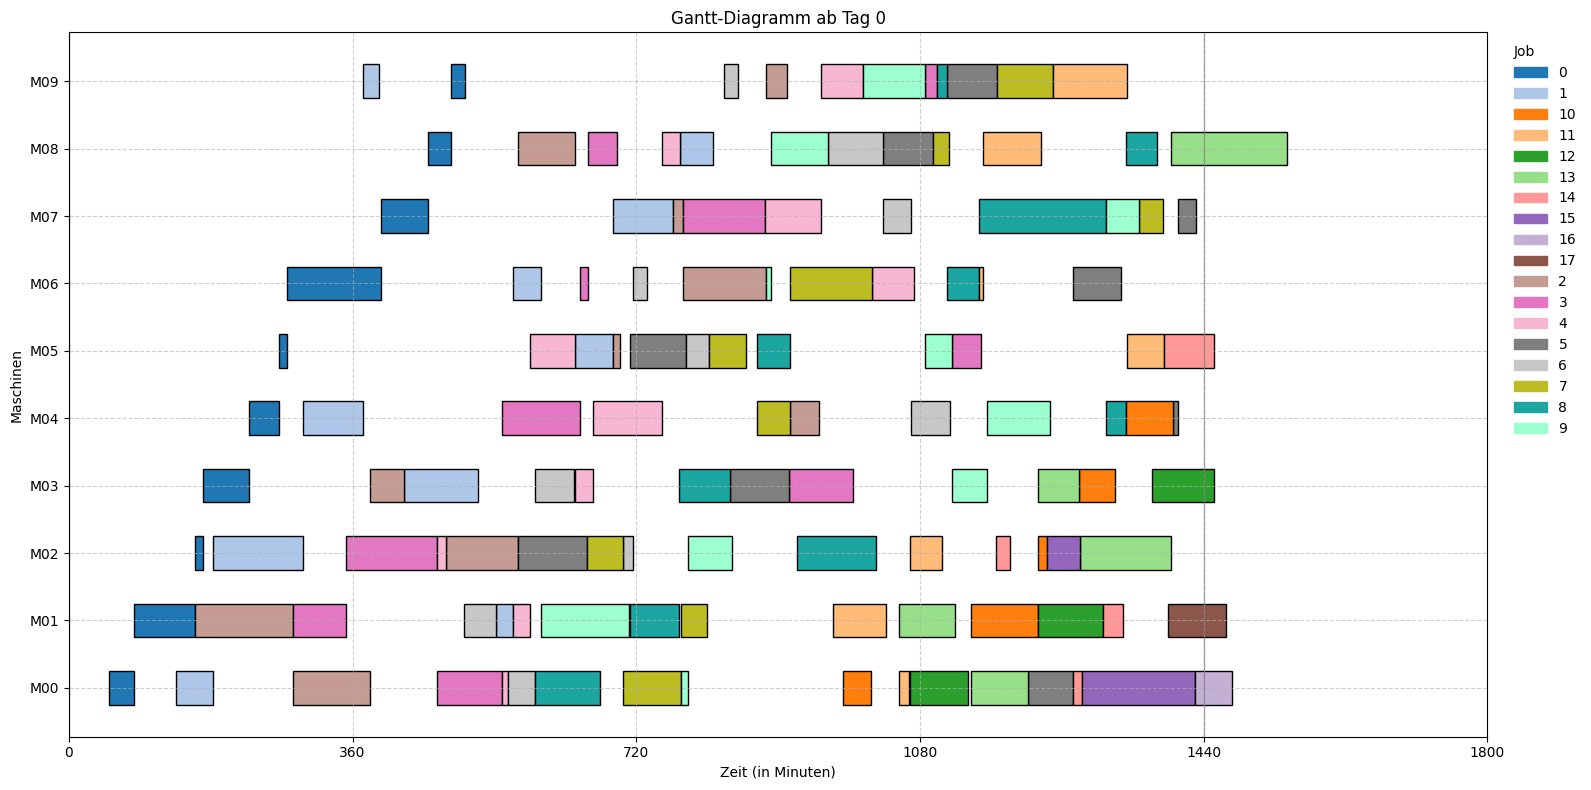

In [12]:
if not df_execution.empty:
    show.plot_gantt(df_execution, perspective="Machine", title=f"Gantt-Diagramm ab Tag {day_numb}")
else:
    print(f"Nothing executed on day {day_numb}")

### b) Verbleibene Jobs (Rest)

In [13]:
df_plan_undone 

,Job,Production_Plan_ID,Operation,Arrival,Machine,Start,Processing Time,Flow time,End
0,7,7,9,528,M03,1134.0,79.0,685.0,1213.0
1,10,0,5,963,M05,1354.0,11.0,402.0,1365.0
2,10,0,6,963,M06,1365.0,62.0,464.0,1427.0
3,10,0,7,963,M07,1427.0,56.0,520.0,1483.0
4,10,0,8,963,M08,1483.0,44.0,564.0,1527.0
5,10,0,9,963,M09,1527.0,21.0,585.0,1548.0
6,11,9,7,969,M03,1322.0,52.0,405.0,1374.0
7,11,9,8,969,M04,1374.0,90.0,495.0,1464.0
...,...,...,...,...,...,...,...,...,...
45,17,3,2,1343,M00,1681.0,71.0,409.0,1752.0


In [14]:
df_job_times_undone = process_filter.update_times_after_operation_changes(df_job_times, df_plan_undone)
df_job_times_undone

,Job,Production_Plan_ID,Arrival
0,7,7,528
1,10,0,963
2,11,9,969
3,12,8,992
4,13,2,1046
5,14,4,1177
6,15,7,1193
7,16,1,1310
8,17,3,1343


## III) Rescheduling
> vereinfacht, ohne neu Aufträge (nur der Rest)

In [15]:
# Reduktion der bereits ausgeführten Operationen auf die relevanten für die nächsten Tage
df_execution_important = df_execution[df_execution["End"] >= 1440]
df_execution_important

,Job,Production_Plan_ID,Operation,Machine,Arrival,Start,Processing Time,End
113,12,8,2,M03,992,1374.00,79.23,1453.23
118,13,2,4,M08,1046,1398.69,147.47,1546.16
122,14,4,3,M05,1177,1390.19,63.04,1453.23
125,16,1,0,M00,1310,1428.67,47.49,1476.16
126,17,3,0,M01,1343,1395.00,72.93,1467.93


In [16]:
df_plan_undone

,Job,Production_Plan_ID,Operation,Arrival,Machine,Start,Processing Time,Flow time,End
0,7,7,9,528,M03,1134.0,79.0,685.0,1213.0
1,10,0,5,963,M05,1354.0,11.0,402.0,1365.0
2,10,0,6,963,M06,1365.0,62.0,464.0,1427.0
3,10,0,7,963,M07,1427.0,56.0,520.0,1483.0
4,10,0,8,963,M08,1483.0,44.0,564.0,1527.0
5,10,0,9,963,M09,1527.0,21.0,585.0,1548.0
6,11,9,7,969,M03,1322.0,52.0,405.0,1374.0
7,11,9,8,969,M04,1374.0,90.0,495.0,1464.0
...,...,...,...,...,...,...,...,...,...
45,17,3,2,1343,M00,1681.0,71.0,409.0,1752.0


In [17]:
df_reschedule = lp_ft_reschedule.solve_jssp_with_fixed_ops(df_plan_undone, df_job_times_undone, 
                                                           df_execution_important, reschedule_start = 1440,
                                                           solver= "HiGHS", msg=False, 
                                                           timeLimit=max_time, gapRel= 0.10)
df_reschedule

BigM: 4000

Solver-Informationen:
  Summe Flow Times        : 7435.0
  Solver-Status           : Optimal
  Anzahl Variablen        : 223
  Anzahl Constraints      : 384
  Laufzeit                : ~0.40 Sekunden


,Job,Production_Plan_ID,Operation,Arrival,Machine,Start,Processing Time,Flow time,End
0,10,0,5,963,M05,1454.0,11.0,502.0,1465.0
1,10,0,6,963,M06,1465.0,62.0,564.0,1527.0
2,10,0,7,963,M07,1527.0,56.0,620.0,1583.0
3,10,0,8,963,M08,1583.0,44.0,664.0,1627.0
4,10,0,9,963,M09,1627.0,21.0,685.0,1648.0
5,11,9,7,969,M03,1454.0,52.0,537.0,1506.0
6,11,9,8,969,M04,1506.0,90.0,627.0,1596.0
7,11,9,9,969,M07,1596.0,45.0,672.0,1641.0
...,...,...,...,...,...,...,...,...,...
45,17,3,3,1343,M04,1863.0,99.0,619.0,1962.0


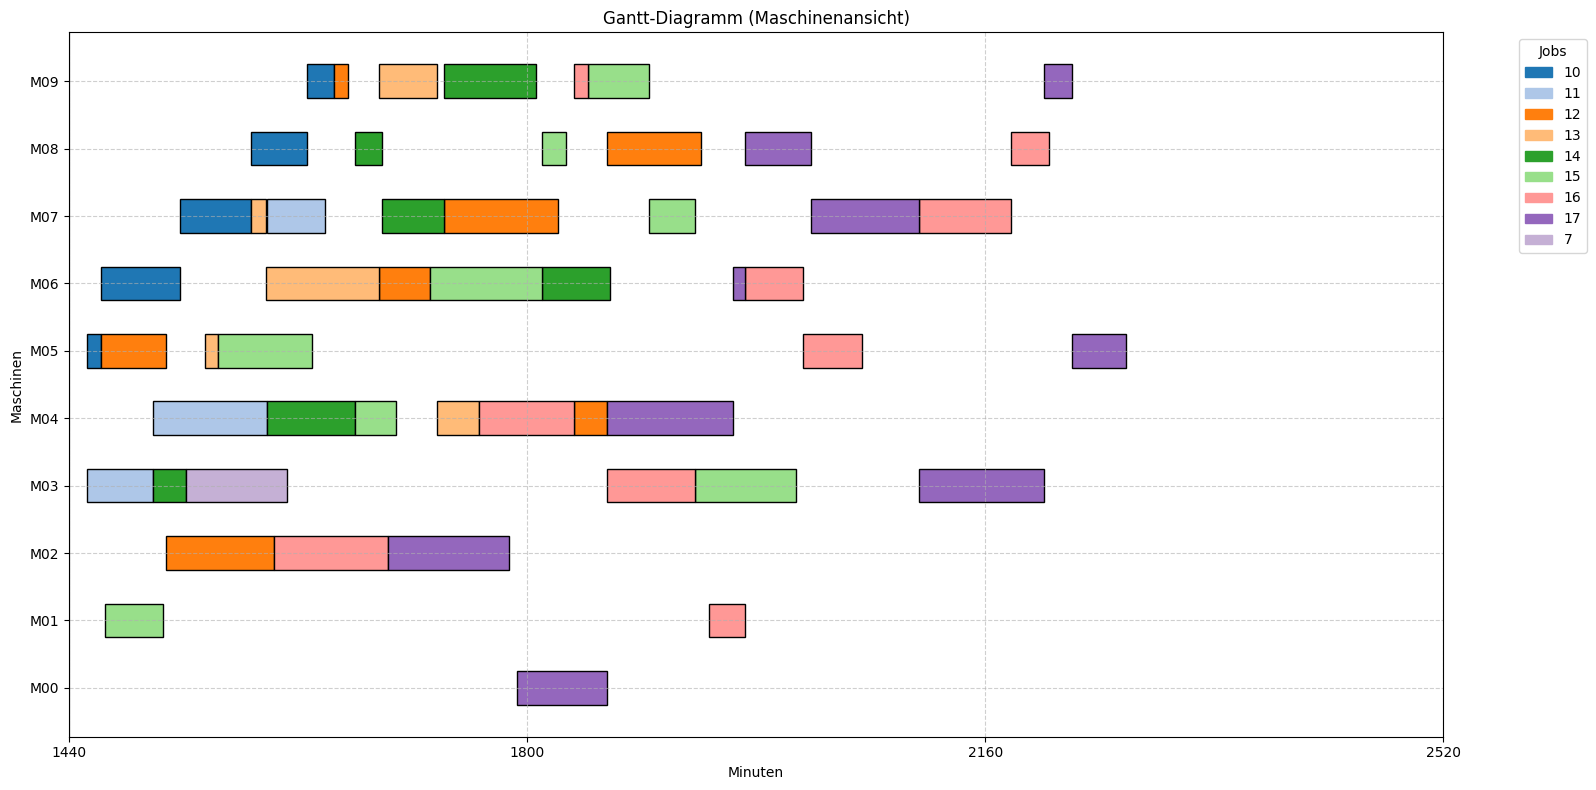

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [18]:
show.plot_gantt_machines(df_reschedule)
check.is_machine_conflict_free(df_reschedule)
check.is_operation_sequence_correct(df_reschedule)
check.is_job_timing_correct(df_reschedule)
check.is_start_correct(df_reschedule)

## Simulation + neuer Schedule 

In [19]:
df_combined = pd.concat([df_execution, df_reschedule], ignore_index=True)
df_combined

,Job,Production_Plan_ID,Operation,Machine,Arrival,Start,Processing Time,End,Flow time
0,0,0,0,M00,51,51.00,31.93,82.93,NaN
1,0,0,1,M01,51,82.93,76.47,159.40,NaN
2,0,0,2,M02,51,159.40,10.81,170.21,NaN
3,0,0,3,M03,51,170.21,58.85,229.06,NaN
4,0,0,4,M04,51,229.06,37.54,266.60,NaN
5,0,0,5,M05,51,266.60,10.17,276.77,NaN
6,0,0,6,M06,51,276.77,119.53,396.30,NaN
7,0,0,7,M07,51,396.30,59.96,456.26,NaN
...,...,...,...,...,...,...,...,...,...
172,17,3,3,M04,1343,1863.00,99.00,1962.00,619.0


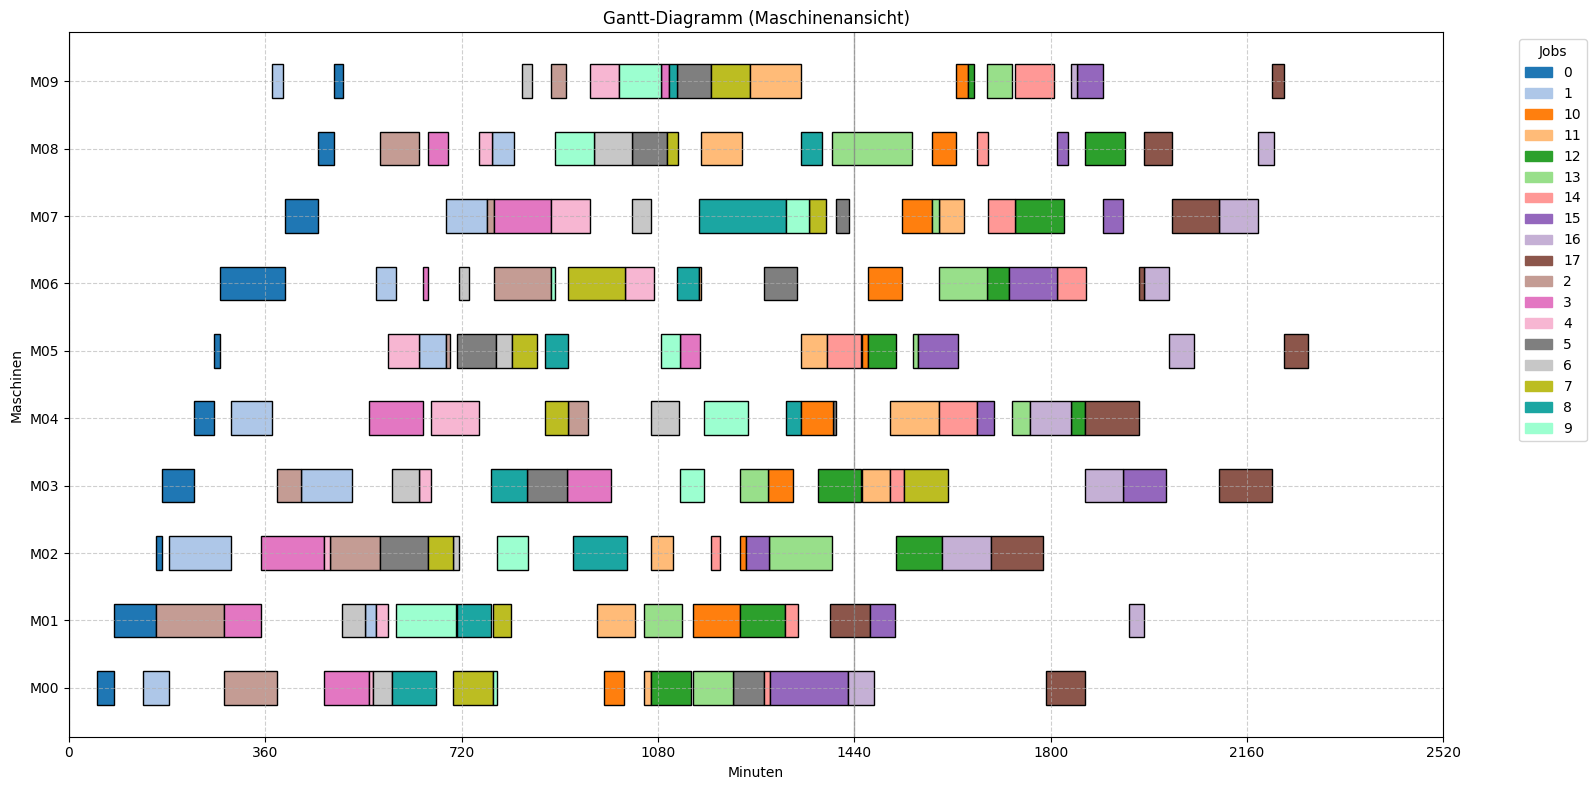

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [20]:
df = df_combined
show.plot_gantt_machines(df)
check.is_machine_conflict_free(df)
check.is_operation_sequence_correct(df)
check.is_job_timing_correct(df)
check.is_start_correct(df)